In [2]:
import pandas as pd
from collections import defaultdict
from pathlib import Path
import numpy as np
import seaborn as sns
from data import rciw_mjhd, rmad_hd, collect_energy_data_paths, get_project_and_benchmark_from_consumption_path, \
    get_normalized_mj_from_file, rmad_hd, rciw_boot

FREQUENCY_MODIFIER = "userspace"
userspace = defaultdict(list)
for path in Path("baseline").rglob(f"{FREQUENCY_MODIFIER}/**/new/sample.json"):
    (proj, bench) = get_project_and_benchmark_from_consumption_path(path)
    userspace[bench].extend(get_normalized_mj_from_file(path).tolist())
userspace = pd.DataFrame(userspace, columns=['nops/100', 'nops/1000', 'nops/10000', 'nops/100000', 'nops/1000000'])

powersave = defaultdict(list)
for path in Path("baseline").rglob(f"powersave/**/new/sample.json"):
    (proj, bench) = get_project_and_benchmark_from_consumption_path(path)
    powersave[bench].extend(get_normalized_mj_from_file(path).tolist())
powersave = pd.DataFrame(powersave, columns=['nops/100', 'nops/1000', 'nops/10000', 'nops/100000', 'nops/1000000'])


import matplotlib.pyplot as plt
import numpy as np
# userspace.boxplot()
# plt.boxplsot(baselines, labels=baselines.columns.to_list())
# print(baselines['nops/10000'])
# (userspace - powersave).median()
# (userspace - powersave).boxplot()

# plt.show()
(userspace.median() - powersave.median()) / userspace.median() * 100
# powersave.median()



nops/100       -2.929468
nops/1000       4.433529
nops/10000      4.257185
nops/100000     4.482548
nops/1000000    4.460738
dtype: float64

In [3]:
import scipy.stats as stats
from bisect import bisect_left

# https://github.com/sealuzh/benchmark-instability-prediction-replication-package/blob/fa6202cd435e02ade885e871df6ecc646ae375d1/study/study_stats_utils.py#L141
def vargha_delaney(x, y):
    x = x.tolist() if isinstance(x, (pd.Series, np.ndarray)) else x
    y = y.tolist() if isinstance(y, (pd.Series, np.ndarray)) else y
    
    # Compute the size of the samples.
    n1, n2 = len(x), len(y)
    
    # Assign ranks to data.
    r = stats.rankdata(x + y)
    r1 = sum(r[0:n1])
    
    # Compute the effect size.
    a = (2 * r1 - n1 * (n1 + 1)) / (2 * n2 * n1)
    
    # Compute magnitude.
    levels = [0.147, 0.33, 0.474]
    magnitude = ['negligible', 'small', 'medium', 'large']
    cliff_d = (a - 0.5) * 2
    mag_lev = bisect_left(levels, abs(cliff_d))
    magnitude = magnitude[bisect_left(levels, abs(cliff_d))]
    
    
    # Return the results.
    return a, magnitude, mag_lev, cliff_d

In [4]:
from scipy.stats import wilcoxon
for column in powersave.columns:
    print(vargha_delaney(powersave[column], userspace[column]))
wilcoxon(powersave, userspace, alternative='greater')
# vargha_delaney(powersave.loc[1], userspace.loc[1])


(0.9910176913580246, 'large', 3, 0.9820353827160493)
(2.802469135802469e-06, 'large', 3, -0.9999943950617284)
(0.0006779259259259259, 'large', 3, -0.9986441481481482)
(9.197530864197531e-06, 'large', 3, -0.9999816049382716)
(0.0003280493827160494, 'large', 3, -0.999343901234568)


WilcoxonResult(statistic=array([4.0494887e+07, 0.0000000e+00, 5.3985000e+04, 0.0000000e+00,
       9.2205000e+03]), pvalue=array([0., 1., 1., 1., 1.]))

In [5]:

rmads = dict()
rciws = dict()
rciws_ps = dict()
rmads_ps = dict()

ITERATIONS = range(1, 31)
SAMPLES_PER_ITERATION = range(25, 301, 25)
for bench in userspace.columns:
    arranged = np.array(userspace[bench]).reshape(30, 300)
    arrangedps = np.array(powersave[bench]).reshape(30, 300)
    for iterations in ITERATIONS:
        for samples in SAMPLES_PER_ITERATION:
            rmads[(bench, iterations, samples)] = float(rmad_hd(arranged[:iterations, :samples]))
            rmads_ps[(bench, iterations, samples)] = float(rmad_hd(arrangedps[:iterations, :samples]))
            rciws[(bench, iterations, samples)] = float(rciw_mjhd(arranged[:iterations, :samples], 0.05))
            rciws_ps[(bench, iterations, samples)] = float(rciw_mjhd(arrangedps[:iterations, :samples], 0.05))
            



In [12]:
rciws_df = pd.Series(np.array(rciws.values()), index=list(rciws.keys()))
ps_df = pd.Series(np.array(rciws_ps.values()), index=list(rciws.keys()))
# rciws_df = rciws_df - ps_df
ps_df.index = pd.MultiIndex.from_tuples(ps_df.index, names=["id", "iterations", "samples"])
ps_df = ps_df.astype(float).sort_index(level=["id", "iterations", "samples"])

rciws_df.index = pd.MultiIndex.from_tuples(rciws_df.index, names=["id", "iterations", "samples"])
rciws_df = rciws_df.astype(float).sort_index(level=["id", "iterations", "samples"])
# rciws_df

rmads_df = pd.Series(np.array(rmads.values()), index=list(rciws.keys()))
rmads_ps_df = pd.Series(np.array(rmads_ps.values()), index=list(rciws.keys()))
rmads_df.index = pd.MultiIndex.from_tuples(rmads_df.index, names=["id", "iterations", "samples"])
rmads_df = rmads_df.astype(float)
rmads_df
# rciws_df

id            iterations  samples
nops/100      1           25         0.001842
                          50         0.001636
                          75         0.001514
                          100        0.001570
                          125        0.001469
                                       ...   
nops/1000000  30          200        0.003523
                          225        0.003584
                          250        0.003625
                          275        0.003666
                          300        0.003710
Length: 1800, dtype: float64

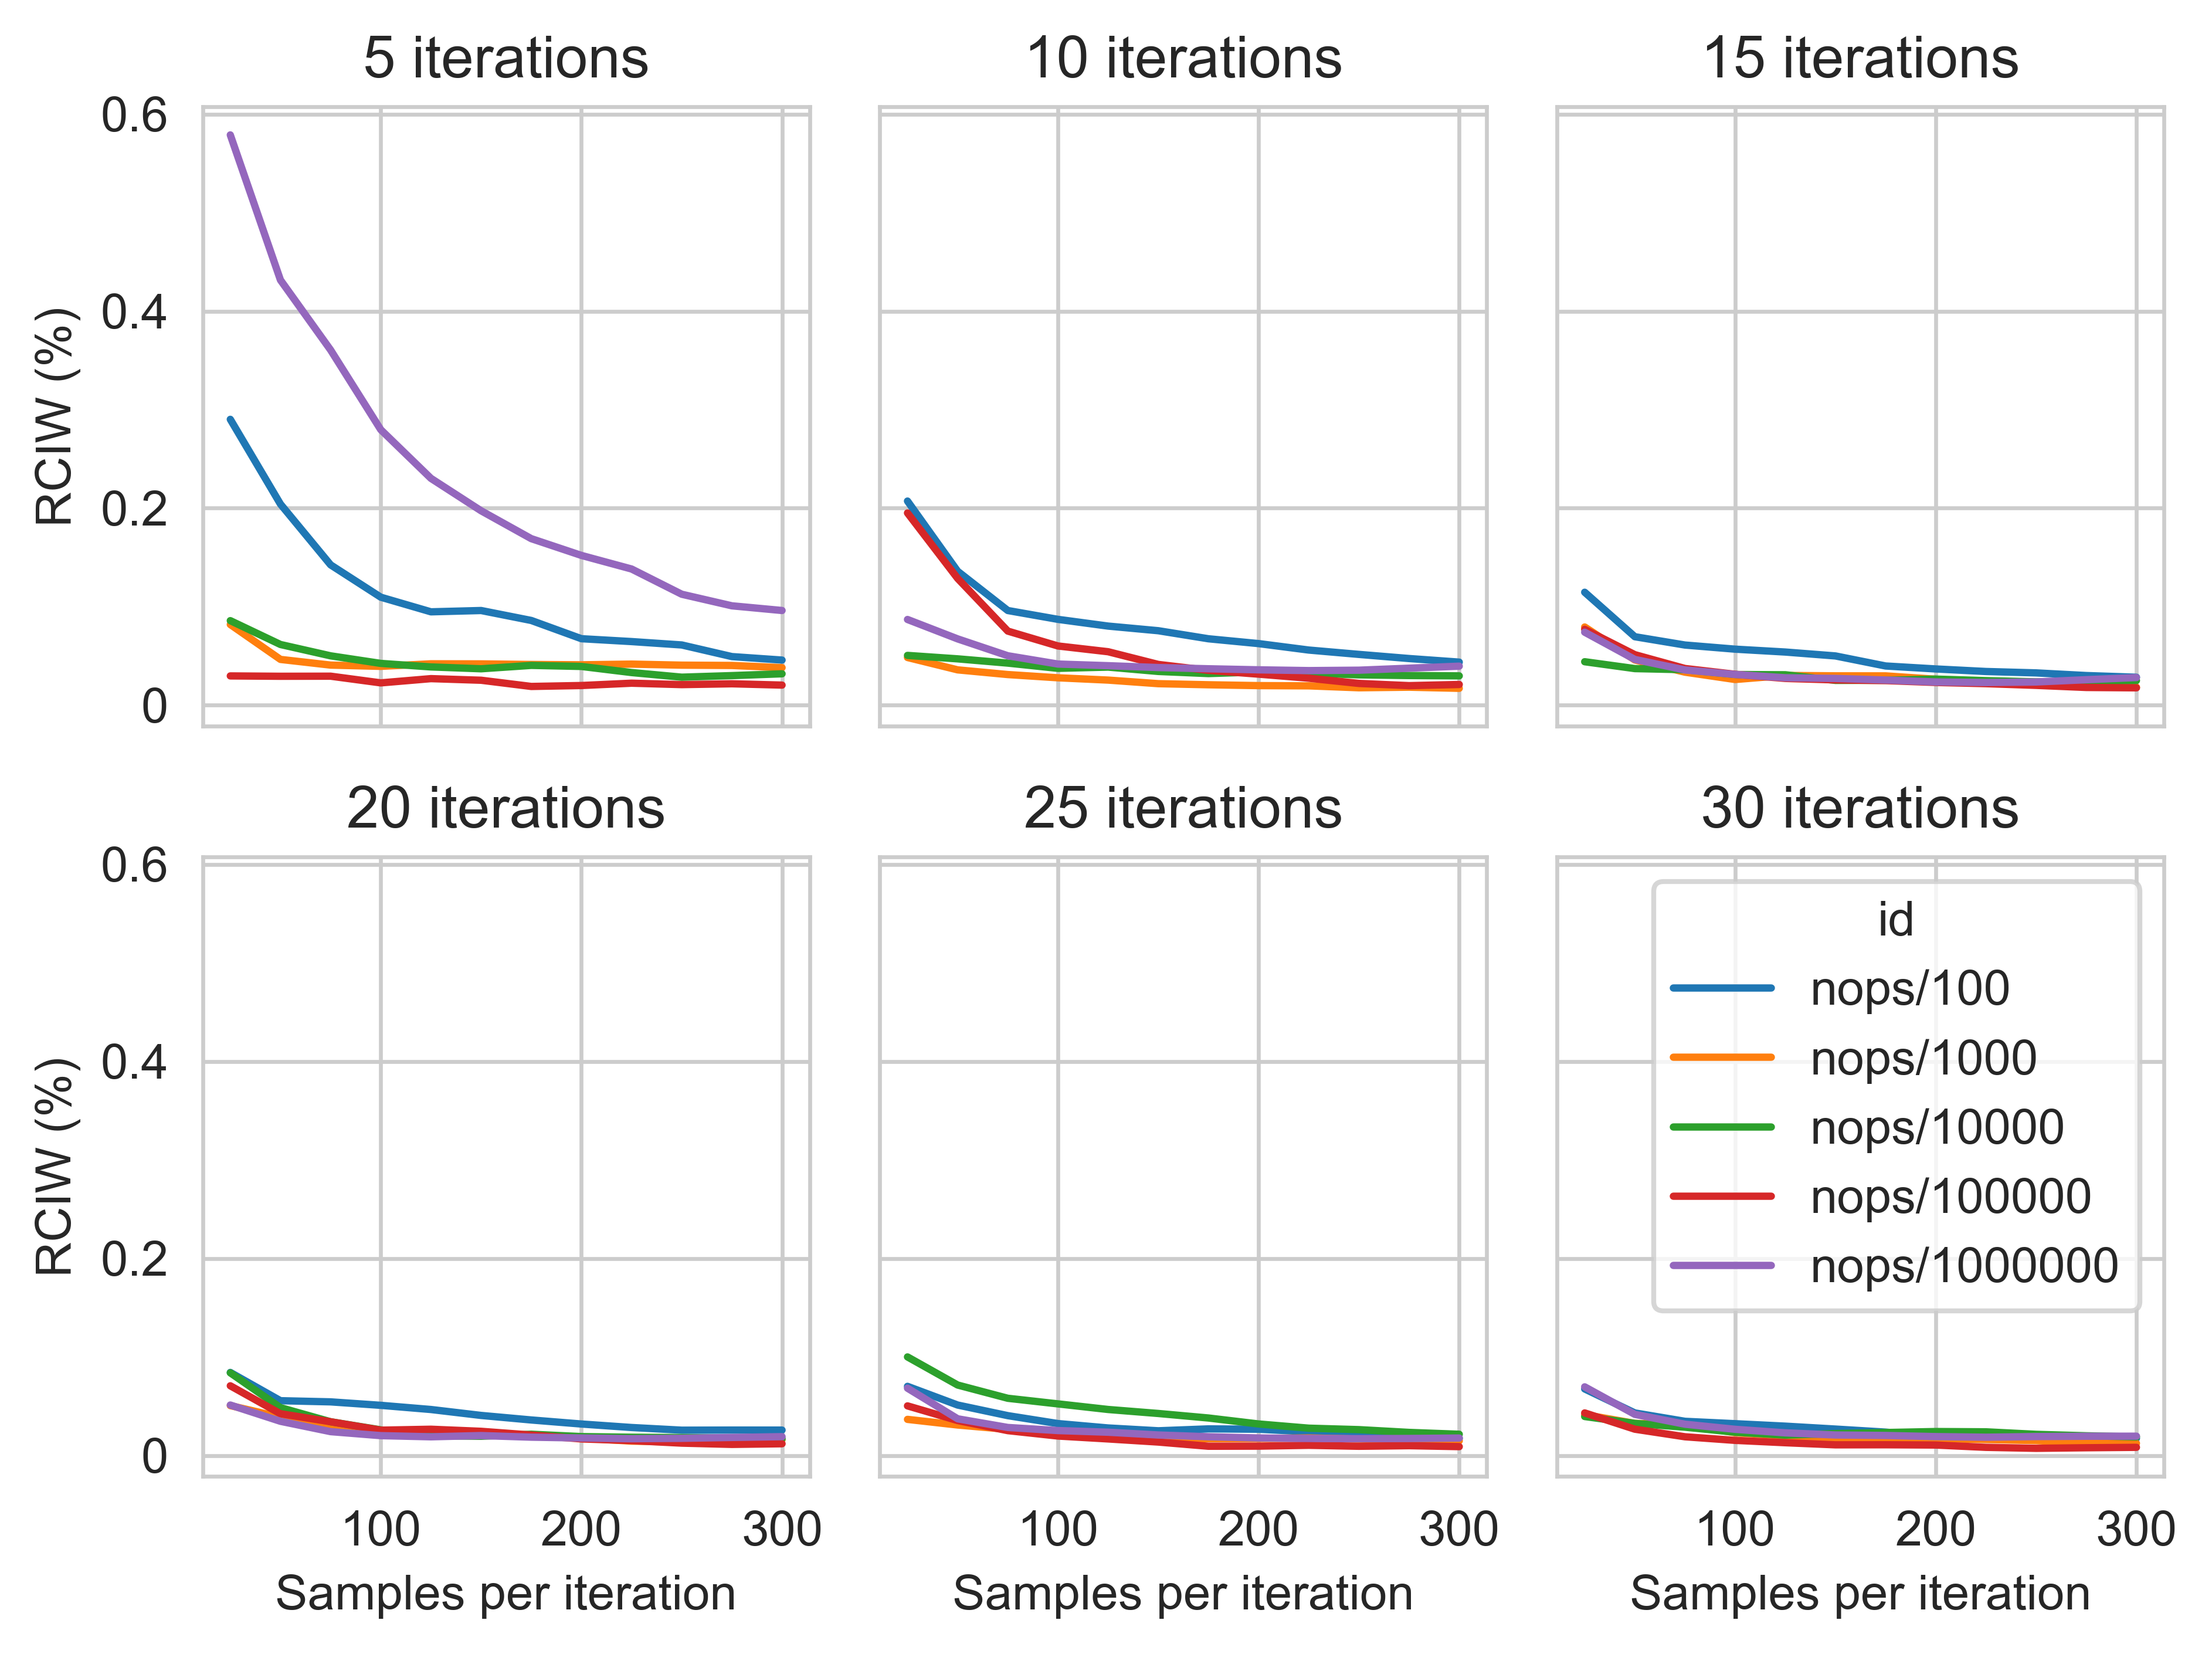

In [7]:
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, dpi=600)

for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    sns.lineplot(rciws_df.loc[(slice(None), s, slice(None))].reset_index(), x='samples', y=0, 
                   units='id', hue='id',
                 legend=idx == 5, ax=ax,
                   estimator=None,
                   )
    # print(medcouple(medians.loc[(slice(None), s, slice(None))], axis=0))
    ax.set_title(f"{s} iterations")
    ax.set_xlabel("Samples per iteration")
    ax.set_yticks([0, 0.2/100, 0.4/100, 0.6/100], ["0", "0.2", "0.4", "0.6"])
    ax.set_ylabel("RCIW (%)")
    ax.set_xlabel("Samples per iteration")
    # ax.set_ylim([0, 1.5])
plt.tight_layout()
# plt.yscale('log')

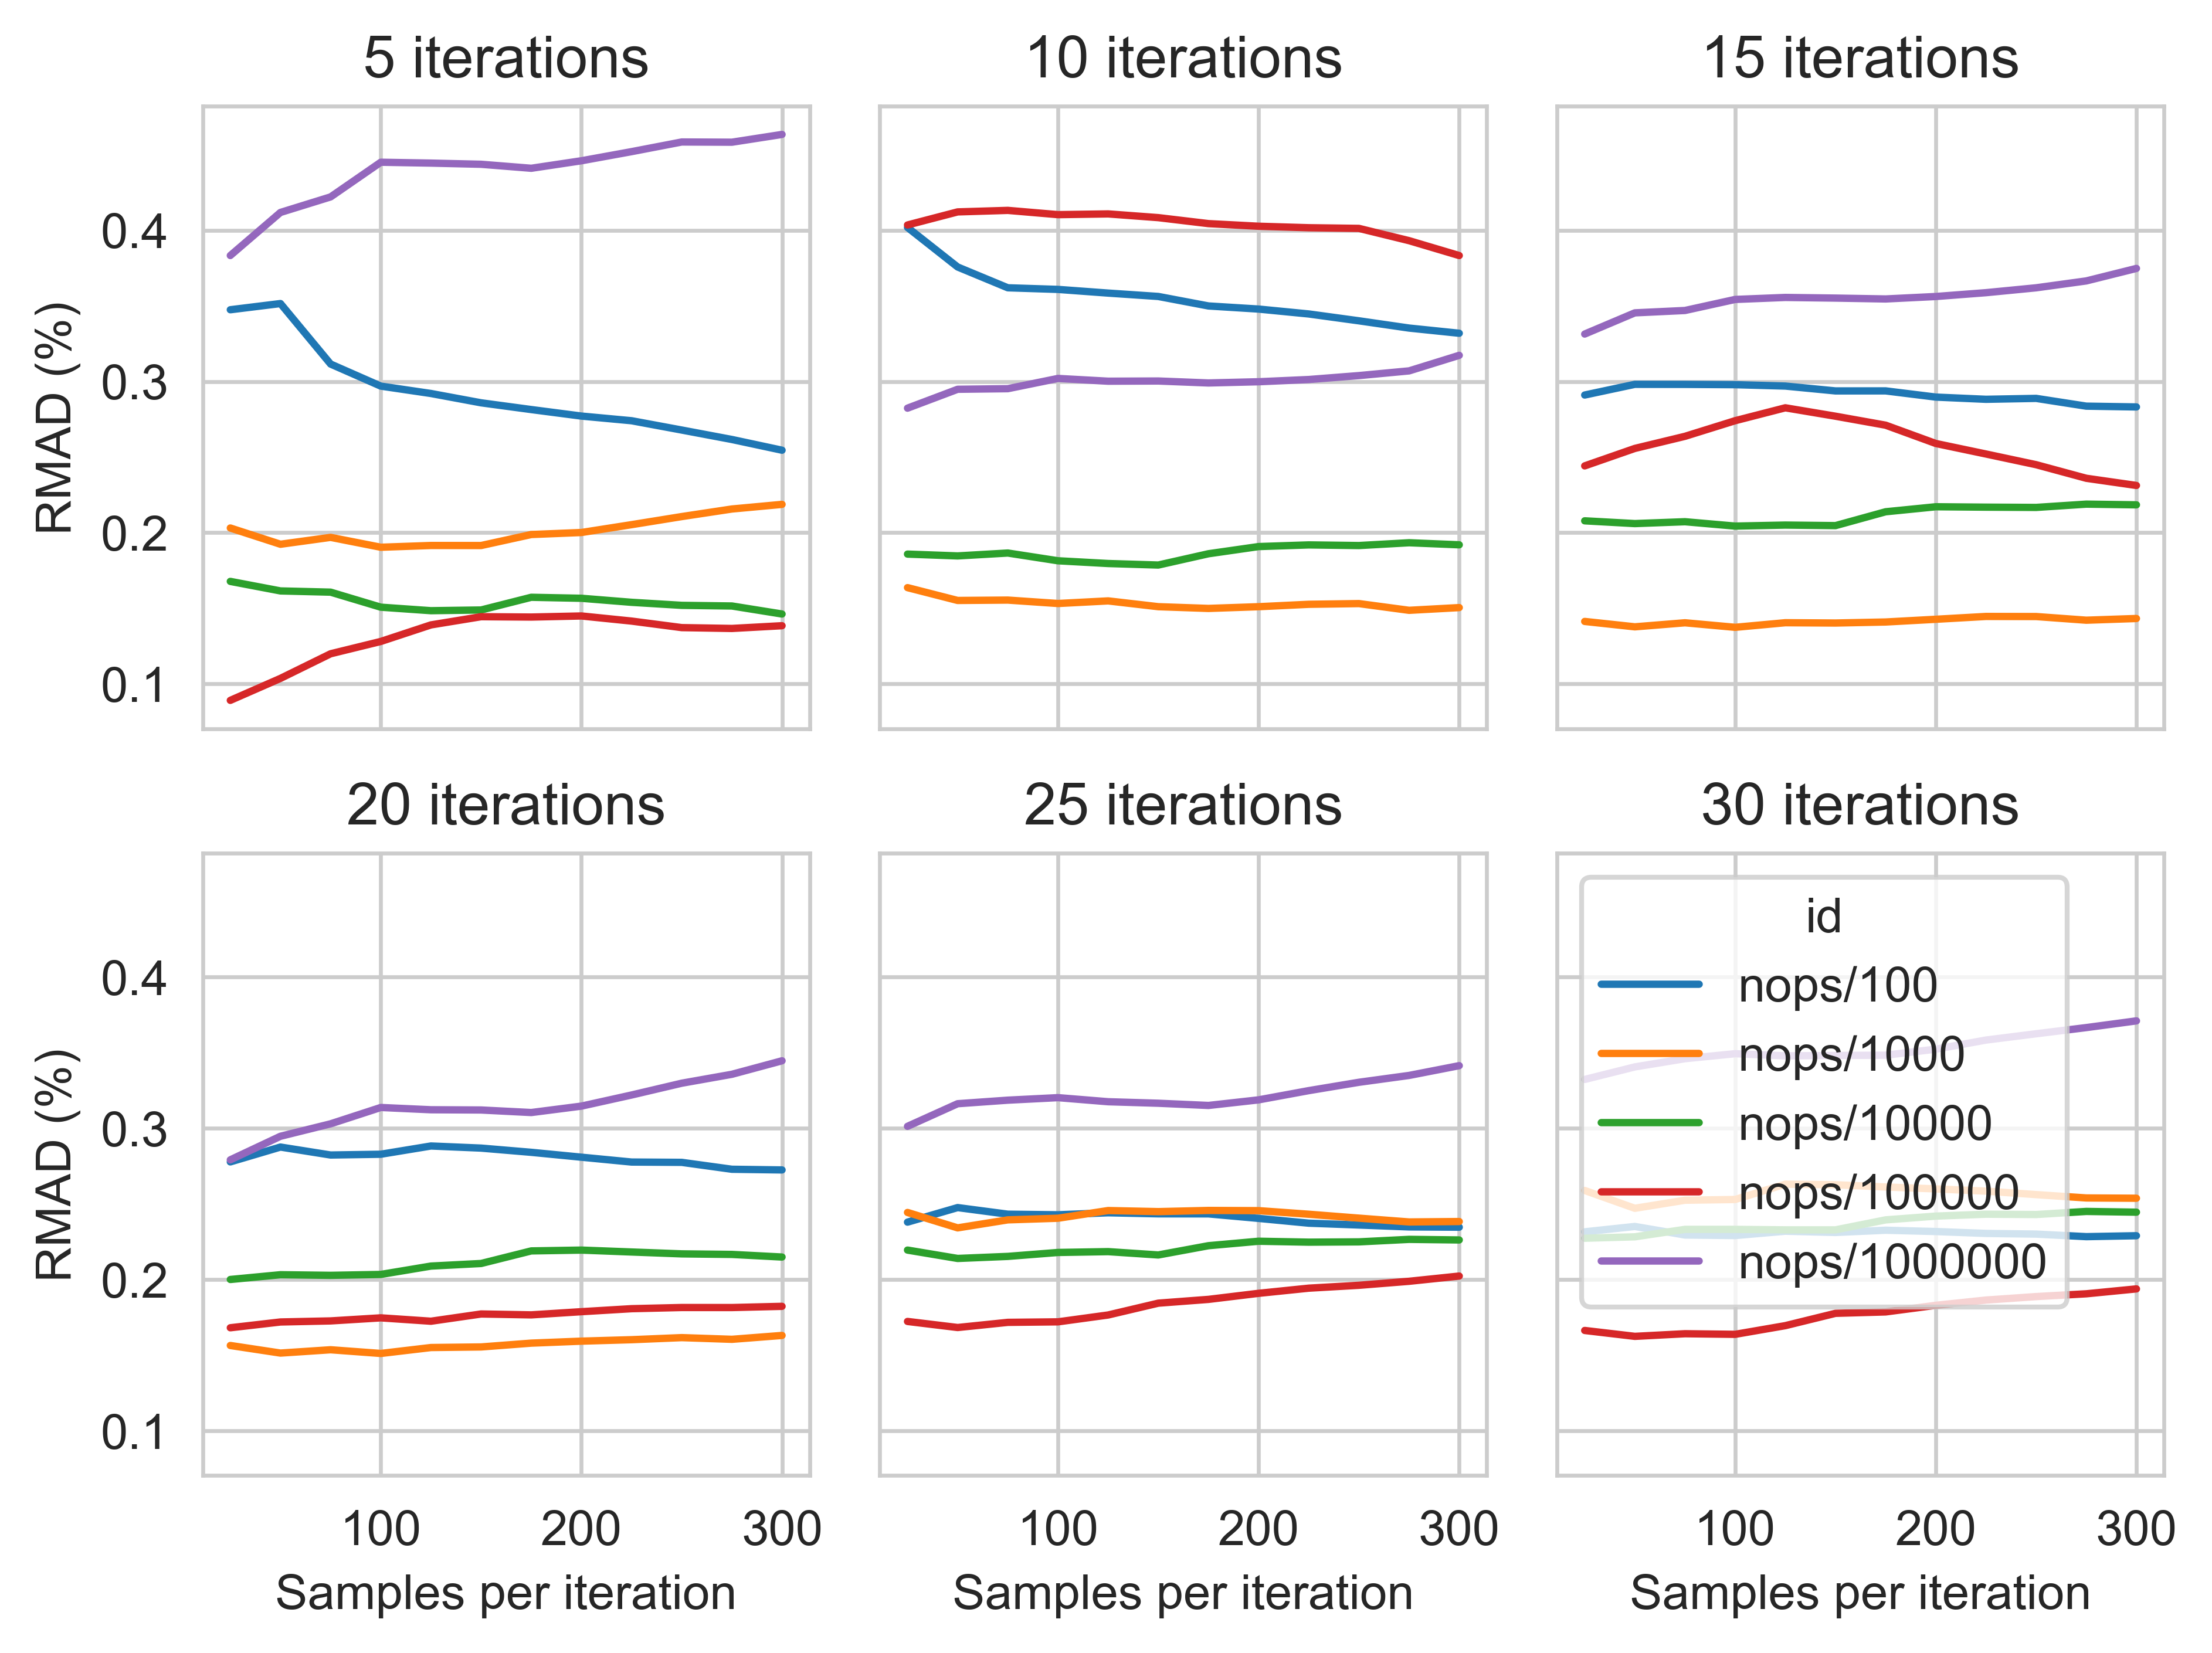

In [16]:
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, dpi=600)

for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    local = rmads_df.loc[(slice(None), s, slice(None))].reset_index()
    local[0] = local[0] * 100

    sns.lineplot(local, x='samples', y=0, 
                   units='id', hue='id',
                 legend=idx == 5, ax=ax,
                   estimator=None,
                   )
    # print(medcouple(medians.loc[(slice(None), s, slice(None))], axis=0))
    ax.set_title(f"{s} iterations")
    ax.set_xlabel("Samples per iteration")
    # ax.set_yticks([0, 0.2/100, 0.4/100, 0.6/100], ["0", "0.2", "0.4", "0.6"])
    ax.set_ylabel("RMAD (%)")
    ax.set_xlabel("Samples per iteration")
    # ax.set_ylim([0, 1.5])
plt.tight_layout()
# plt.yscale('log')

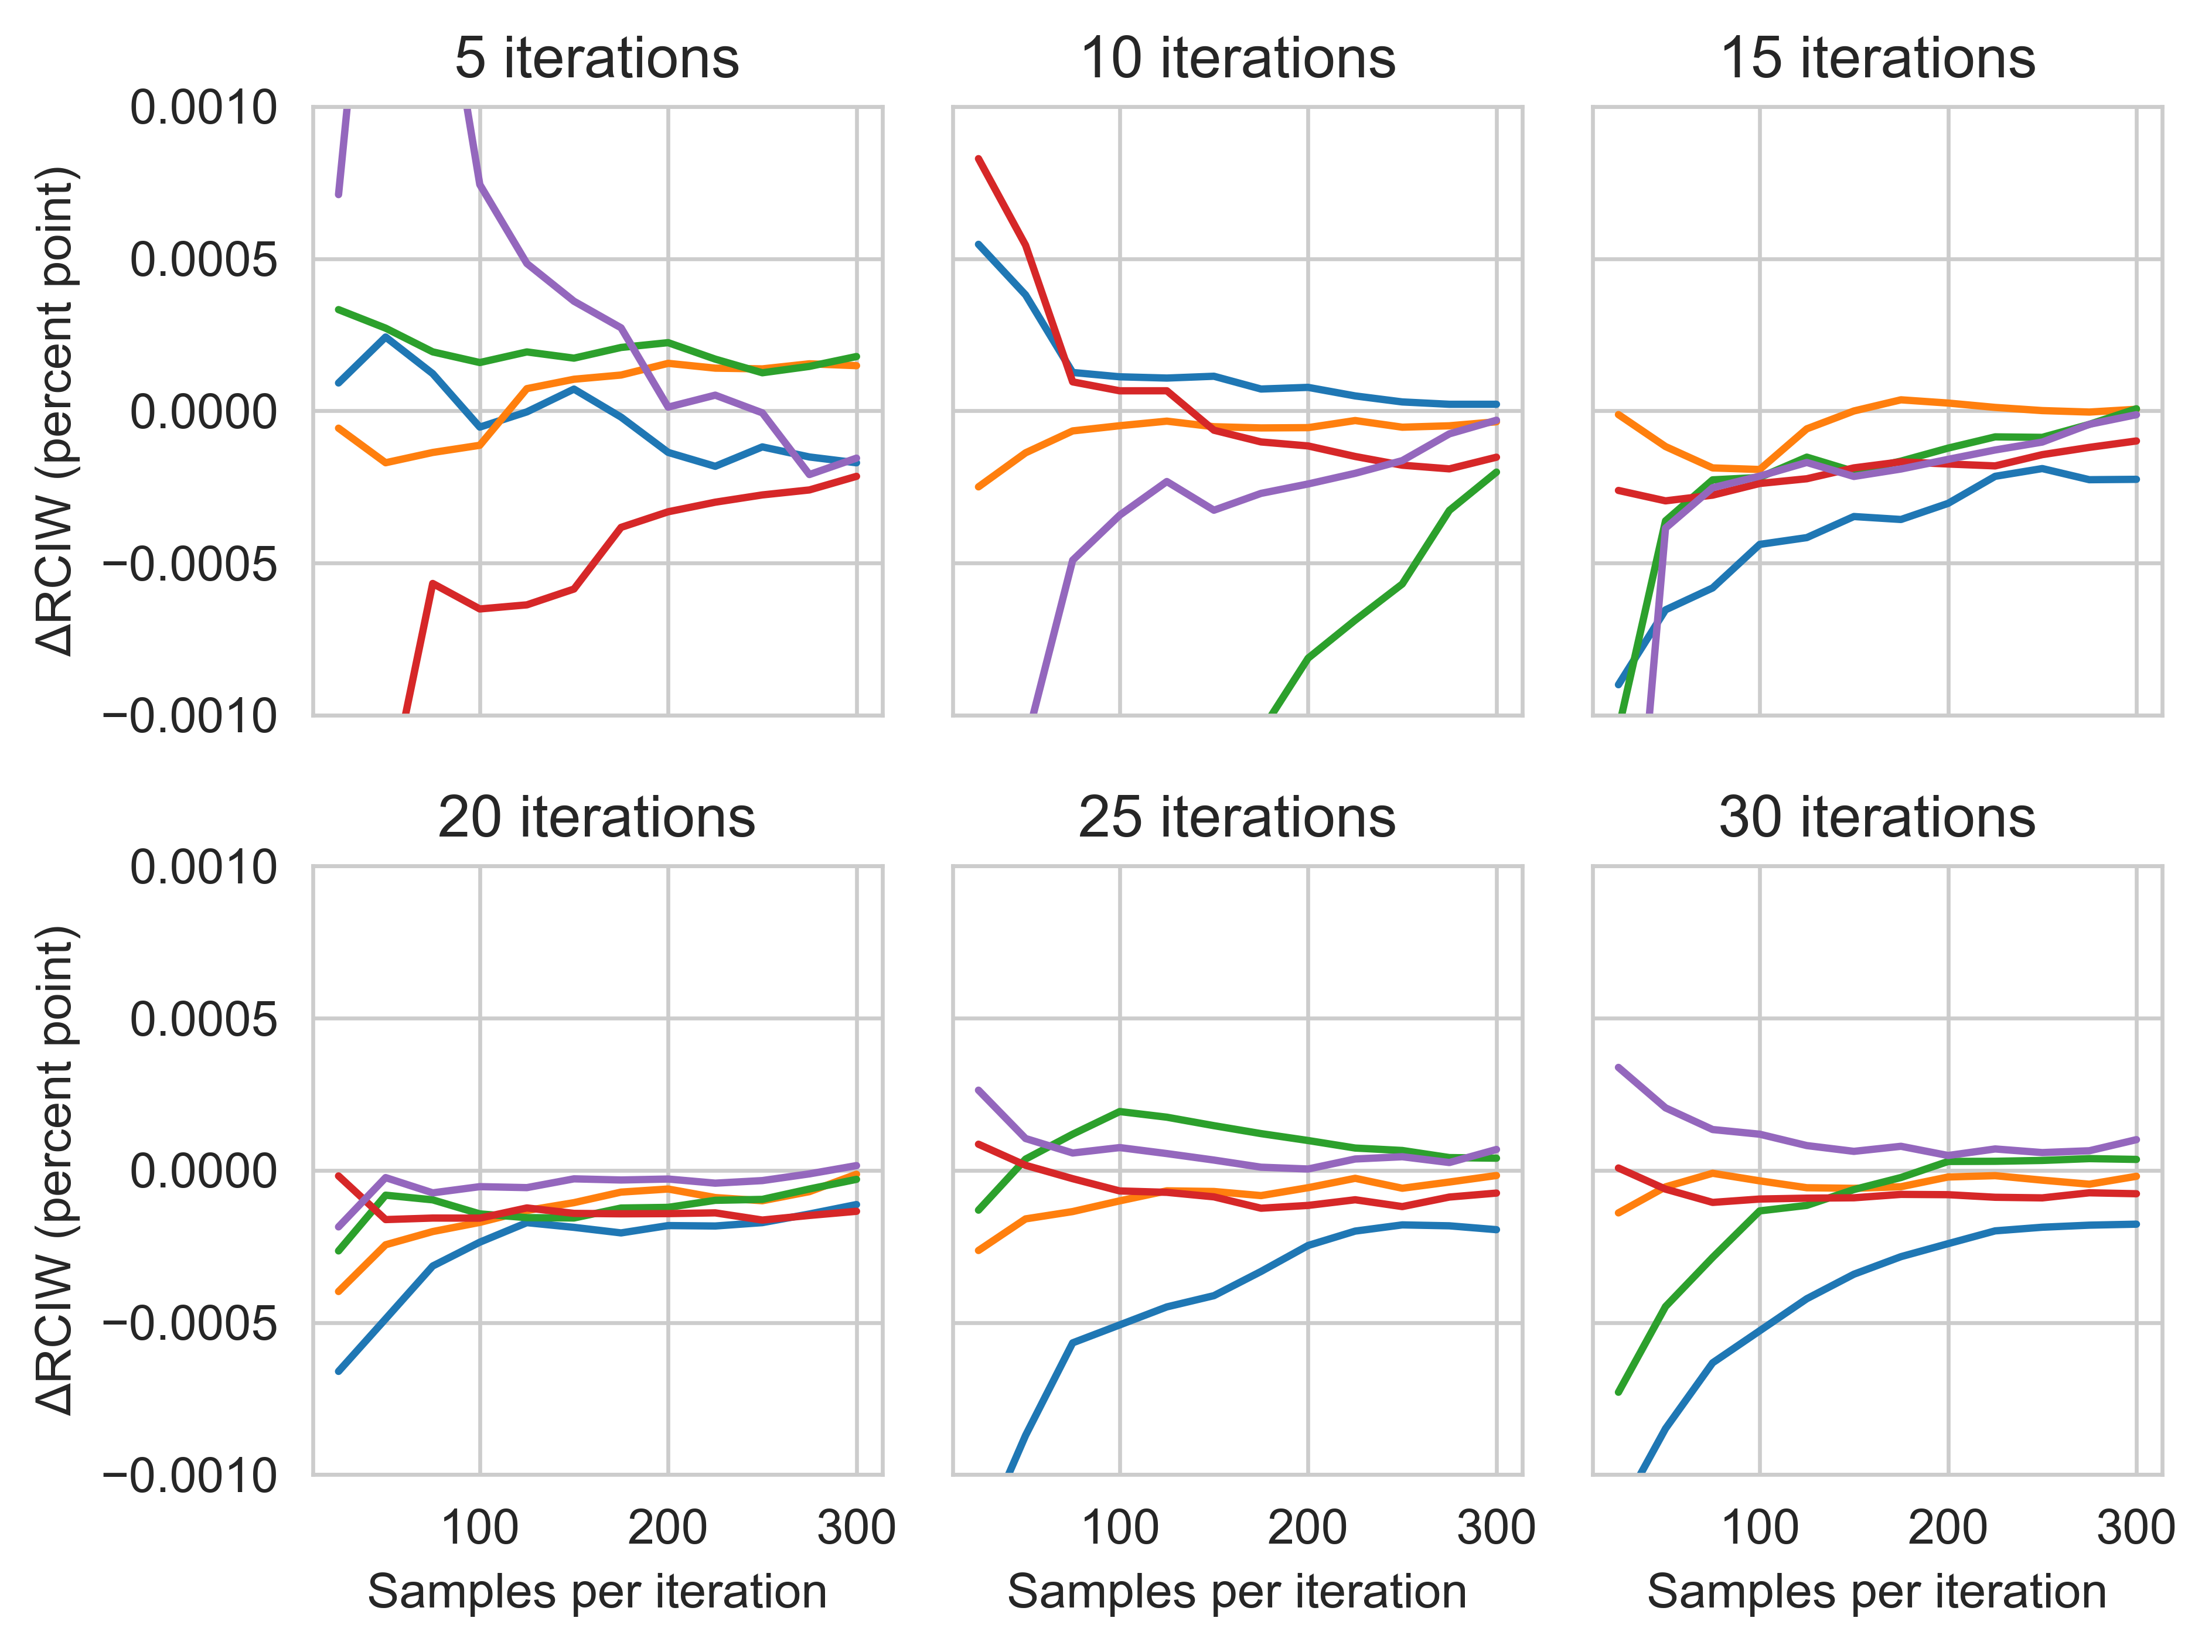

In [35]:
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, dpi=600)

for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    sns.lineplot((rciws_df.loc[(slice(None), s, slice(None))] - ps_df.loc[(slice(None), s, slice(None))]).reset_index(), x='samples', y=0, 
                   units='id', hue='id',
                 legend=False, ax=ax,
                   estimator=None,
                   )
    # print(medcouple(medians.loc[(slice(None), s, slice(None))], axis=0))
    ax.set_title(f"{s} iterations")
    ax.set_xlabel("Samples per iteration")
    # ax.set_yticks([0, 0.2/100, 0.4/100, 0.6/100], ["0", "0.2", "0.4", "0.6"])
    ax.set_ylabel("ΔRCIW (percent point)")
    ax.set_xlabel("Samples per iteration")
    ax.set_ylim([-0.001, 0.001])
plt.tight_layout()
# plt.yscale('log')yybxzvbbnm\\


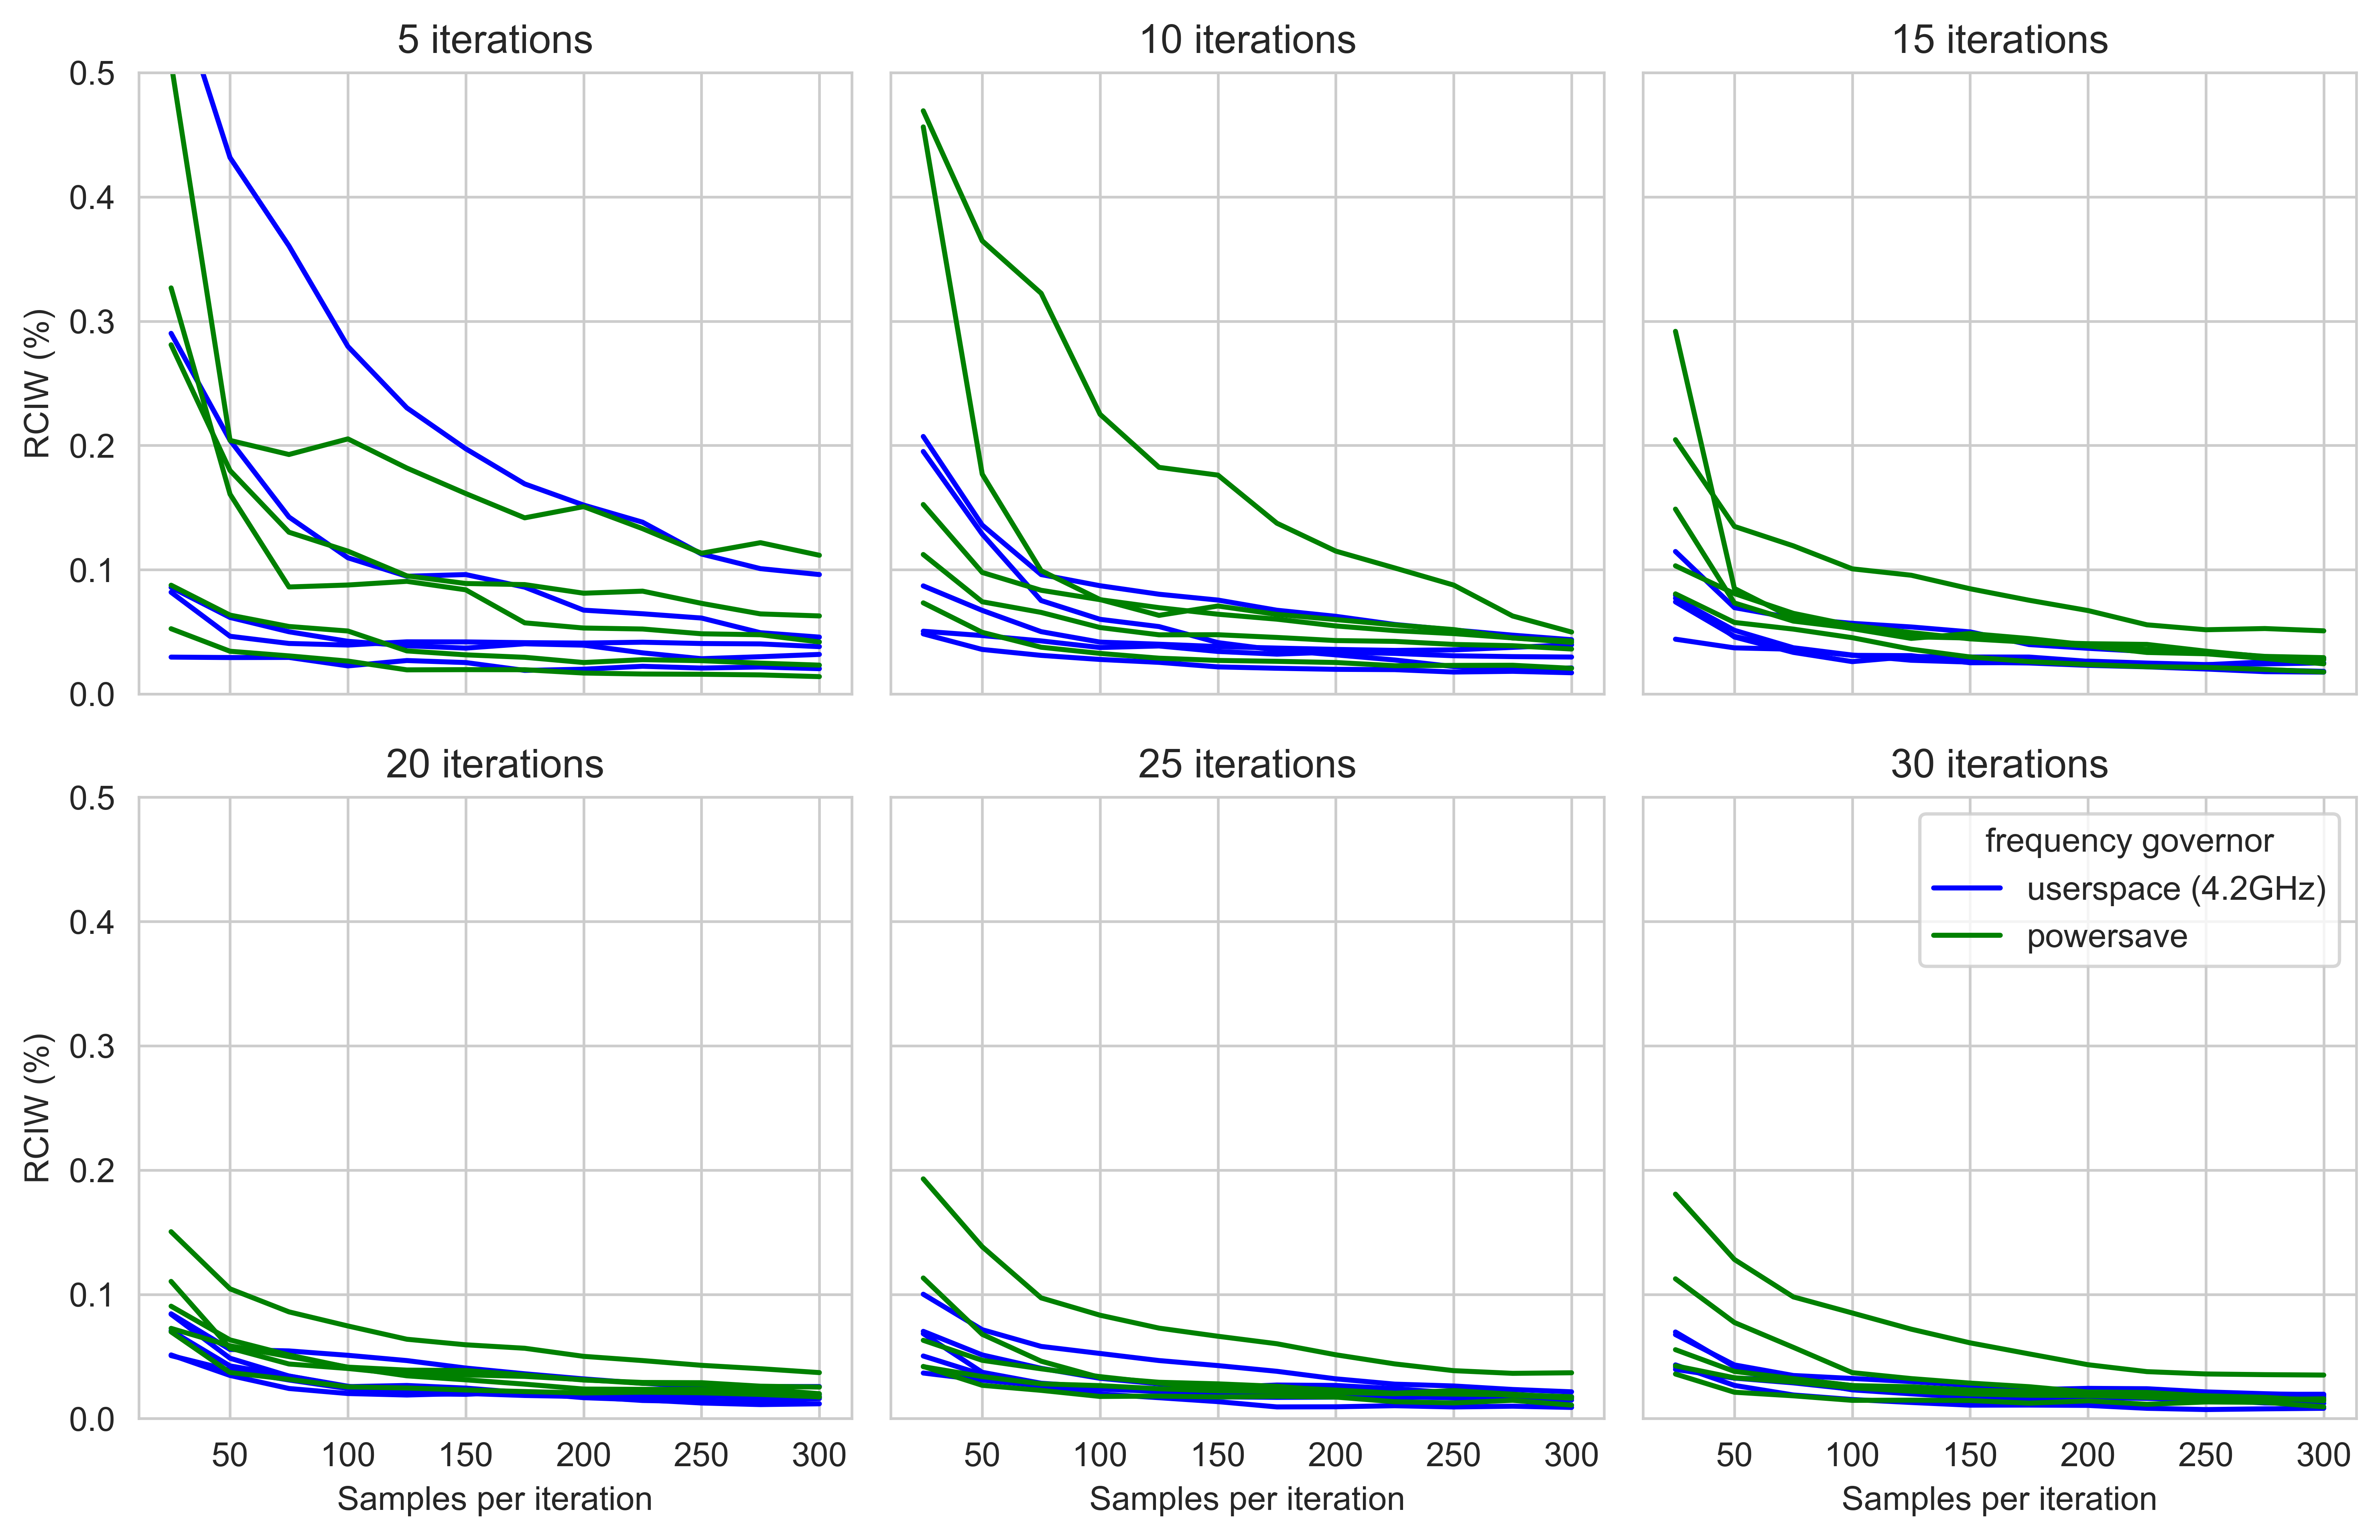

In [36]:
import seaborn as sns
import matplotlib.lines as mlines
# iters = range(1,31)
iters = range(5,31, 5)
order = np.array(rciws_df.index.get_level_values('id').unique()).sort()
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6.5), dpi=600)
# local = rciw.loc[(slice(None), i, slice(None))]
ll = rciws_df.reset_index(level='samples')
llps = ps_df.reset_index(level='samples')
ll[0] = ll[0] * 100
llps[0] = llps[0] * 100

for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    perf = sns.lineplot(ll.loc[(slice(None), s, slice(None))], x='samples', y=0,
                 ax=ax, color='blue', estimator=None, units='id')
    ps = sns.lineplot(llps.loc[(slice(None), s, slice(None))], x='samples', y=0 ,
                 ax=ax, color='green', estimator=None, units='id')
    ax.set_title(f"{s} iterations")
    ax.set_ylabel("RCIW (%)")
    ax.set_xlabel("Samples per iteration")
    ax.set_ylim([0, 0.5])
    if idx == 5:
        ax.legend(handles=[mlines.Line2D([], [], color='blue', marker=None,
                          markersize=15, label='userspace (4.2GHz)'),
                   mlines.Line2D([], [], color='green', marker=None,
                          markersize=15, label='powersave')], title="frequency governor")

# axs.flatten()[2].legend(rciws_df.index.get_level_values('id').unique())
# axs.flatten()[-1].legend()
plt.tight_layout()

rciw    0.016041
Name: (30, 300), dtype: float64

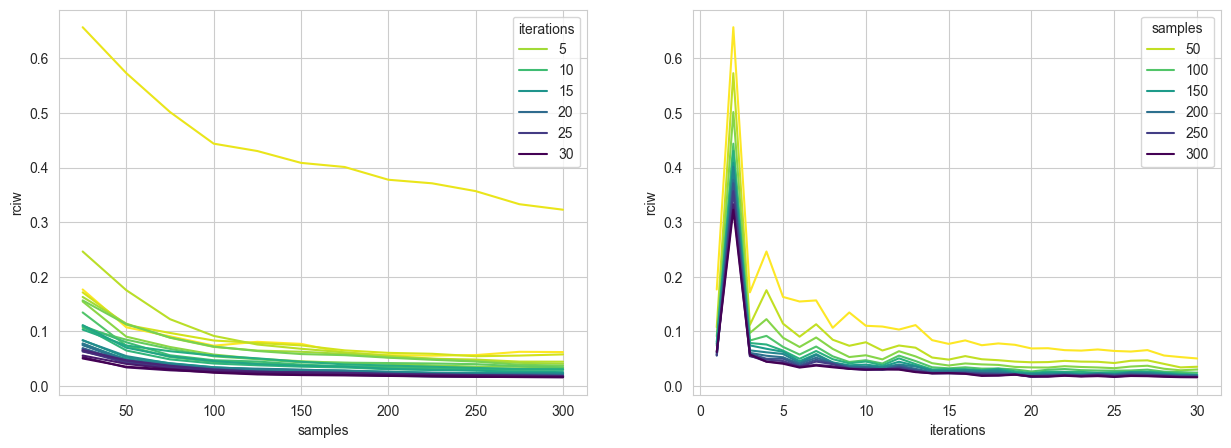

In [37]:
import scipy
from data import custom_mquantiles_cimh_hd


def med_hj(data):
    return float(np.ma.getdata(scipy.stats.mstats.hdmedian(data, axis=0)))


ll = rciws_df.reset_index(level='samples')
# ll['rciw'] = ll['rciw'] * 1000
ll[0] *= 100
regular_medians = ll.groupby(['iterations', 'samples']).median()
hj_medians = ll.groupby(['iterations', 'samples']).apply(lambda df: med_hj(df[0]),
                                                         include_groups=False).reset_index().rename(columns={0: 'rciw'})
# hj_medians
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(hj_medians, x='samples', y='rciw', units='iterations', hue='iterations', legend=True, palette='viridis_r',
             estimator=None, ax=axs[0])
sns.lineplot(hj_medians, x='iterations', y='rciw', units='samples', hue='samples', legend=True, palette='viridis_r',
             estimator=None, ax=axs[1])
# 
# axs[0].set_xlabel("Samples taken per iteration")
# axs[1].set_ylabel("RCIW (%)")
# axs[1].set_ylabel("RCIW (%)")
# axs[1].set_xlabel("Number of iterations used")
hj_medians.set_index(['iterations', 'samples']).loc[30, 300]

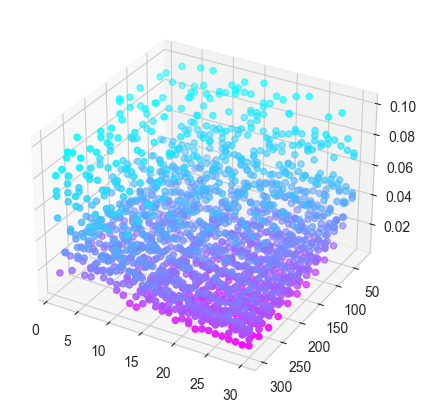

In [38]:
plt.figure(figsize=(6, 5))
axes = plt.axes(projection="3d")
data = rciws_df.to_frame() * 100
data = data.rename(columns ={0:'rciw'})
# data = data.sort_index(level=['iterations', 'samples'], ascending=[1,1])
data = data.reset_index()
data = data.loc[data['rciw'] < 0.1]
axes.scatter(data['iterations'], data['samples'],data['rciw'], c=np.log10(data['rciw']), cmap='cool_r')
# ax.yaxis.
axes.invert_yaxis() 
# data

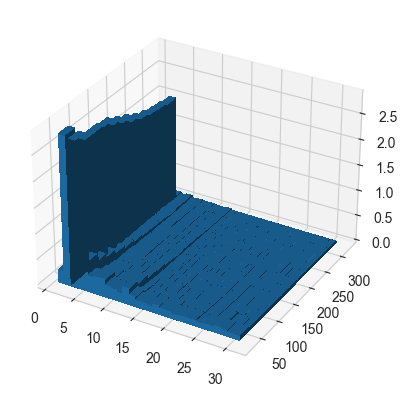

In [39]:
data = rciws_df.to_frame() * 100
data = data.groupby(level=[1,2]).max().reset_index()

axes = plt.axes(projection="3d")
axes.bar3d(data['iterations'], data['samples'],0, 1, 25, data[0], cmap='cool', antialiased=False, linewidth=0, )

-2.064868299371399 1.3944835236109887


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

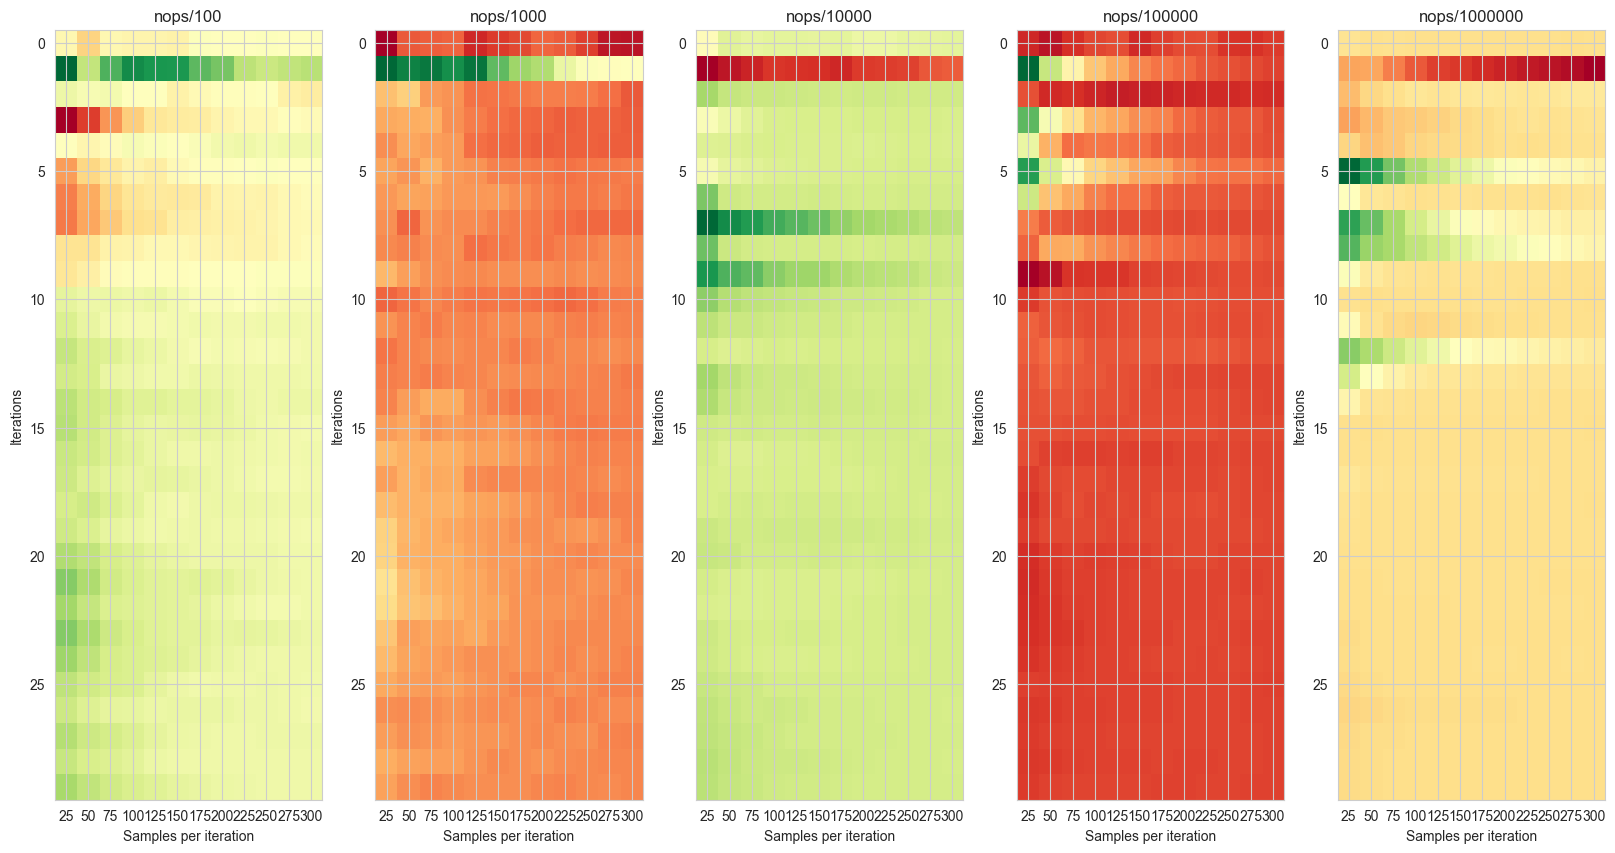

In [40]:
import matplotlib
fig = plt.figure(figsize=(20, 10), )

data = (rciws_df - ps_df) * 100
im = None
_min, _max = data.min(axis=None), data.max(axis=None)
print(_min, _max)
# colormappable=matplotlib.cm.ScalarMappable(matplotlib.colors.TwoSlopeNorm(vmin=_min, vmax=_max, vcenter=0.0), cmap='RdYlGn_r')
colormappable=matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=_min, vmax=_max), cmap='RdYlGn_r')
for idx, bench in enumerate(sorted(set(data.index.get_level_values(0)))):
    ax = fig.add_subplot(1, len(set(data.index.get_level_values(0))), idx + 1)
    reshaped = np.array(data[bench]).reshape(len(ITERATIONS), len(SAMPLES_PER_ITERATION))
    im = ax.imshow(reshaped, cmap=colormappable.get_cmap(),  aspect='auto')
    ax.set_xticks(range(len(SAMPLES_PER_ITERATION)))
    ax.set_xticklabels(SAMPLES_PER_ITERATION)
    ax.set_xlabel("Samples per iteration")
    ax.set_ylabel("Iterations")
    ax.set_title(bench)
plt.colorbar(colormappable)
fig.suptitle(f"RCIW percentage-points difference for NOP loops of size nops/<n>\nFrequency governor: userspace - powersave\n red -> powersave more stable")
plt.show()

In [41]:
from scipy.special import kl_div, rel_entr
from scipy.stats import ttest_rel, wilcoxon

# sum(kl_div(ps_df, rciws_df))
print("Two-sided:", wilcoxon(ps_df.values, rciws_df.values, alternative='two-sided').pvalue)
# print("Reject equality, they are different")
# print("PS Greater:", wilcoxon(ps_df.values, rciws_df.values, alternative='greater').pvalue)
print("Userspace greater:", wilcoxon(rciws_df.values, ps_df.values, alternative='less').pvalue)

Two-sided: 2.0948667795917822e-57
Userspace greater: 1.0474333897958911e-57


Text(0.5, 1.0, 'VD A12 magnitude of RCIW(PS) > RCIW(USER)')

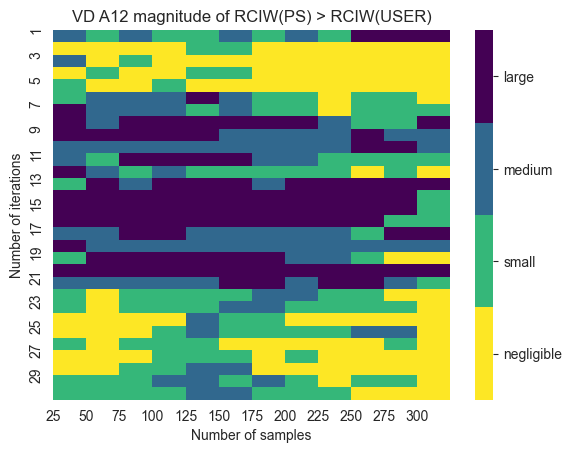

In [42]:
import itertools
import scipy.stats as stats
import matplotlib



fig = plt.figure()
# VDA = [[VD_A(ps_df[:, i, s], rciws_df[:, i, s]) for s in range(25,301,25)]  for i in range(1, 31)]
VDA = [[vargha_delaney(ps_df[:, i, s], rciws_df[:, i, s])[2] for s in range(25,301,25)]  for i in range(1, 31)]
norm = matplotlib.colors.BoundaryNorm([0, 0.147, 0.33, 0.474, 1], 4)
scalar = matplotlib.cm.ScalarMappable(norm=norm, )
heatmap = sns.heatmap(VDA, vmin=0, vmax=3, cmap=matplotlib.colormaps.get_cmap('viridis_r').resampled(4), cbar=True, cbar_kws={'ticks': np.arange(1,5) * 3/4 - 3/8})
plt.yticks(range(0,30,2), list(map(str, range(1,31,2))))
plt.xticks(range(12), list(map(str, range(25, 301, 25))))
# plt.colorbar(scalar, ax=heatmap)
fig.axes[-1].set_yticklabels(['negligible', 'small', 'medium', 'large'])  # vertically oriented colorbar
heatmap.set_xlabel('Number of samples')
heatmap.set_ylabel('Number of iterations')
heatmap.set_title("VD A12 magnitude of RCIW(PS) > RCIW(USER)")

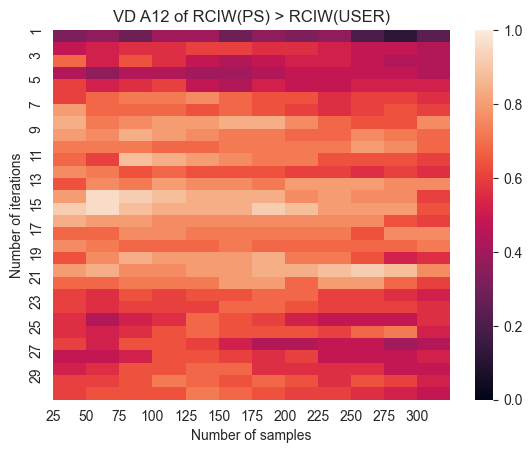

In [43]:
heatmap = sns.heatmap([[vargha_delaney(ps_df[:, i, s], rciws_df[:, i, s])[0] for s in range(25,301,25)]  for i in range(1, 31)], vmin=0, vmax=1, )
heatmap.set_xlabel('Number of samples')
heatmap.set_ylabel('Number of iterations')
heatmap.set_title("VD A12 of RCIW(PS) > RCIW(USER)")
plt.yticks(range(0,30,2), list(map(str, range(1,31,2))))
plt.xticks(range(12), list(map(str, range(25, 301, 25))))
pass

Text(0, 0.5, 'Difference magnitude')

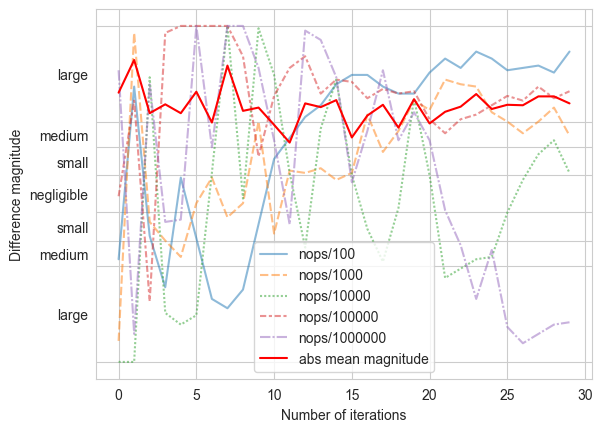

In [67]:
d = defaultdict(list)
w = defaultdict(list)
for id, group in rciws_df.groupby('id'):
    for iter, group in group.groupby('iterations'):
        VDA = vargha_delaney(ps_df[id, iter], group)
        d[id] += [VDA[3]]
        w[id] += [wilcoxon(ps_df[id, iter].to_list(), group.to_list(), alternative='less').pvalue]

        # print(id, iter, VDA)
# np.mean(list(d.values())), np.median(list(d.values()))
fig, ax = plt.subplots(1,1, squeeze=False)
ax = ax.flatten()

sns.lineplot(pd.DataFrame(d), alpha=0.5, ax=ax[0])
sns.lineplot(x=range(30), y=pd.DataFrame(d).abs().mean(axis=1), label="abs mean magnitude", color='red', ax=ax[0])
cliffDedges = [-1, -0.43, -0.28, -0.11, .11, .28, .43, 1]
minor = list(map(np.mean, itertools.pairwise(cliffDedges)))
ax[0].set_yticks(cliffDedges, minor=False, labels=[])
ax[0].set_yticks(minor, minor=True, labels=['large', 'medium', 'small', 'negligible', 'small','medium', 'large' ])
ax[0].yaxis.grid(True, which='major')
ax[0].yaxis.grid(False, which='minor')
ax[0].set_xlabel("Number of iterations")
ax[0].set_ylabel("Difference magnitude")


# sns.lineplot(w, ax=ax[1])

In [ ]:
hj_medians = rciws_df.groupby(['iterations', 'samples']).apply(lambda df: med_hj(df),
                                                         include_groups=False).reset_index().rename(columns={0: 'rciw'})
hj_medians_ps = ps_df.groupby(['iterations', 'samples']).apply(lambda df: med_hj(df),
                                                         include_groups=False).reset_index().rename(columns={0: 'rciw'})
print(vargha_delaney(hj_medians, hj_medians_ps))
print(vargha_delaney(rciws_df, ps_df))